In [1]:
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.6.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

## Read and preprocess the data 

Source: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [5]:
df = pd.read_csv('../data/household_power_consumption.txt', sep=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0
2075258,26/11/2010,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [7]:
df.shape

(2075259, 9)

In [8]:
# Check for missing values
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [9]:
# Plot Sub_metering_3 to see if there is a noticeable gap in missing values. 
# Useful to see if there are a lot of consecutive 
# missing values.

na_groups = df['Sub_metering_3'].notna().cumsum()[df['Sub_metering_3'].isna()]
len_consecutive_na = na_groups.groupby(na_groups).agg(len)

longest_na_gap = len_consecutive_na.max()
longest_na_gap

7226

In [10]:
# Remove Sub_metering_3 column as the length of consecutive missing values
# is too large to fill with another value

df = df.drop(['Sub_metering_3'], axis=1)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000


In [11]:
df.dtypes

Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
dtype: object

In [12]:
# Transform all values to numeric except for date and time

cols_to_convert = df.columns[2:]

df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [13]:
df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
dtype: object

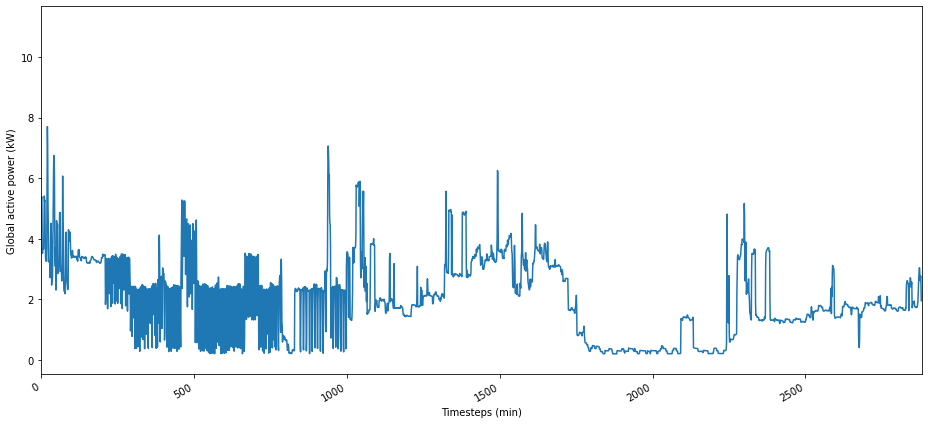

In [14]:
# Plot first 24h (2880 min) of target

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(df['Global_active_power'])
ax.set_xlabel('Timesteps (min)')
ax.set_ylabel('Global active power (kW)')
ax.set_xlim(0, 2880)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH18_F03_peixeiro.png', dpi=300)

In [15]:
# Create new datetime column to have date formatted correctly
df.loc[:,'datetime'] = pd.to_datetime(df.Date.astype(str) + ' ' + df.Time.astype(str))

# Drop old date and tiem columns
df = df.drop(['Date', 'Time'], axis=1)

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,2006-12-16 17:28:00


In [16]:
# Sample hourly sum to see if we get a more visible pattern
hourly_df = df.resample('H', on='datetime').sum()

hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0


In [17]:
# Drop first and last row of data so that we have only full 24h sums

hourly_df = hourly_df.drop(hourly_df.tail(1).index)
hourly_df = hourly_df.drop(hourly_df.head(1).index)

hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


In [18]:
hourly_df.shape

(34949, 6)

In [19]:
hourly_df = hourly_df.reset_index()

hourly_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


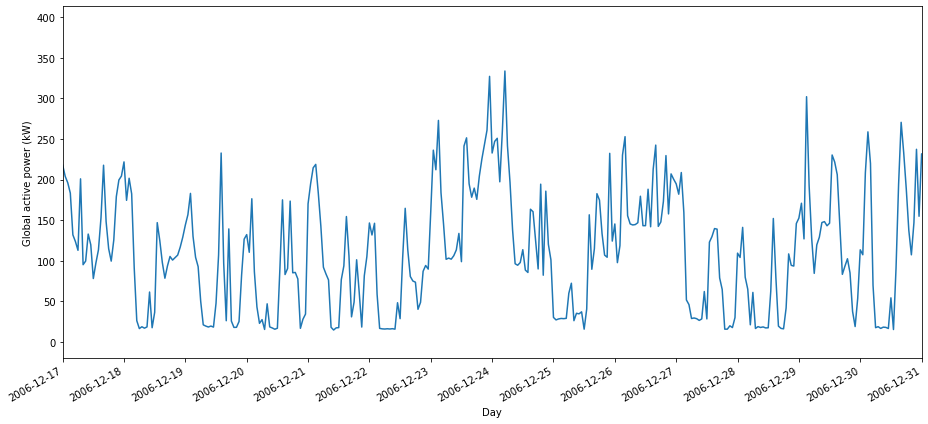

In [20]:
# Plot first 15 full days of target

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(hourly_df['Global_active_power'])
ax.set_xlabel('Day')
ax.set_ylabel('Global active power (kW)')
ax.set_xlim(0, 336)

plt.xticks(np.arange(0, 360, 24), ['2006-12-17', '2006-12-18', '2006-12-19', '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23', '2006-12-24', '2006-12-25', '2006-12-26', '2006-12-27', '2006-12-28', '2006-12-29', '2006-12-30', '2006-12-31'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH18_F04_peixeiro.png', dpi=300)

In [21]:
hourly_df.to_csv('../data/clean_household_power_consumption.csv', header=True, index=False)

## Feature engineering 

In [22]:
hourly_df = pd.read_csv('../data/clean_household_power_consumption.csv')
hourly_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


In [23]:
hourly_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34949.0,64.002817,54.112103,0.0,19.974,45.868,93.738,393.632
Global_reactive_power,34949.0,7.253838,4.113238,0.0,4.558,6.324,8.884,46.460
Voltage,34949.0,14121.298311,2155.548246,0.0,14340.300,14454.060,14559.180,15114.120
Global_intensity,34949.0,271.331557,226.626113,0.0,88.400,196.600,391.600,1703.000
Sub_metering_1,34949.0,65.785430,210.107036,0.0,0.000,0.000,0.000,2902.000
Sub_metering_2,34949.0,76.139861,248.978569,0.0,0.000,19.000,39.000,2786.000


In [24]:
hourly_df = hourly_df.drop(['Sub_metering_1'], axis=1)
hourly_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,8.0


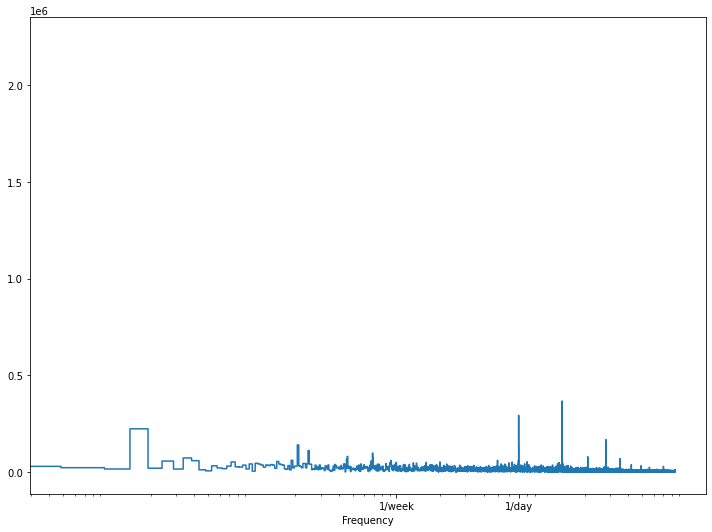

<Figure size 720x540 with 0 Axes>

In [25]:
fft = tf.signal.rfft(hourly_df['Global_active_power'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(hourly_df['Global_active_power'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

plt.savefig('figures/CH18_F06_peixeiro.png', dpi=300)

In [26]:
timestamp_s = pd.to_datetime(hourly_df.datetime).map(datetime.datetime.timestamp)

day = 24 * 60 * 60

hourly_df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
hourly_df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [27]:
hourly_df = hourly_df.drop(['datetime'], axis=1)

hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,day_sin,day_cos
0,217.932,4.802,14074.81,936.0,403.0,-2.588190e-01,0.965926
1,204.014,5.114,13993.95,870.2,86.0,-7.065073e-12,1.000000
2,196.114,4.506,14044.29,835.0,0.0,2.588190e-01,0.965926
3,183.388,4.600,14229.52,782.8,25.0,5.000000e-01,0.866025
4,132.008,3.370,14325.60,571.4,8.0,7.071068e-01,0.707107


## Split data and scale it

In [28]:
n = len(hourly_df)

# Split 70:20:10 (train:validation:test)
train_df = hourly_df[0:int(n*0.7)]
val_df = hourly_df[int(n*0.7):int(n*0.9)]
test_df = hourly_df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((24464, 7), (6990, 7), (3495, 7))

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

## Save to CSV files 

In [30]:
train_df.to_csv('../data/ch18_train.csv', index=False, header=True)
val_df.to_csv('../data/ch18_val.csv', index=False, header=True)
test_df.to_csv('../data/ch18_test.csv', index=False, header=True)